In [2]:
%%capture
%run pre_processing.ipynb




In [3]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


Load EfficientNet_B0

In [5]:
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
model = efficientnet_b0(weights=weights)


In [6]:
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)

In [7]:
for param in model.features.parameters():
    param.requires_grad = False


In [8]:
model = model.to(device)

Loss + Optimizer + Class Weights

In [10]:

# نفترض أن عندك train_df وفيه عمود اسمه "label" يحتوي أرقام الكلاسات
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label_id']),
    y=train_df['label_id']
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class Weights:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)



Class Weights: tensor([ 0.4381,  0.6007, 14.1667,  0.7113,  0.5724, 17.0000,  2.1795,  0.4570,
         7.7273,  0.5592,  5.8621, 28.3333])


Train One Epoch Function and Evaluation Function

In [11]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()  # وضع التدريب
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()          # تصفير التدرجات
        outputs = model(images)        # forward
        loss = criterion(outputs, labels)  # حساب الخسارة
        loss.backward()                # backprop
        optimizer.step()               # تحديث الأوزان

        running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs, 1)   # أعلى احتمال = الكلاس المتوقّع
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc


In [12]:
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()   # وضع التقييم (يعطّل Dropout/BatchNorm updates)
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc



Loop training

In [13]:
num_epochs = 15  # كبداية، نقدر نغيرها بعدين
best_val_acc = 0.0

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )
    val_loss, val_acc = evaluate(
        model, val_loader, criterion, device
    )

    print(f"Epoch {epoch}/{num_epochs}")
    print(f"  Train  -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"  Val    -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # حفظ أفضل موديل بناءً على دقة الـ validation
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_efficientnet_b0_weighted.pth")

        print("  ✅ New best model saved!")


Epoch 1/15
  Train  -> Loss: 2.3793, Acc: 0.2088
  Val    -> Loss: 2.2011, Acc: 0.3867
  ✅ New best model saved!
Epoch 2/15
  Train  -> Loss: 2.1659, Acc: 0.4127
  Val    -> Loss: 1.9877, Acc: 0.5423
  ✅ New best model saved!
Epoch 3/15
  Train  -> Loss: 1.9761, Acc: 0.4794
  Val    -> Loss: 1.8010, Acc: 0.5652
  ✅ New best model saved!
Epoch 4/15
  Train  -> Loss: 1.8356, Acc: 0.5402
  Val    -> Loss: 1.6700, Acc: 0.5927
  ✅ New best model saved!
Epoch 5/15
  Train  -> Loss: 1.7216, Acc: 0.5510
  Val    -> Loss: 1.5692, Acc: 0.6156
  ✅ New best model saved!
Epoch 6/15
  Train  -> Loss: 1.6569, Acc: 0.5598
  Val    -> Loss: 1.4618, Acc: 0.6156
Epoch 7/15
  Train  -> Loss: 1.5330, Acc: 0.5853
  Val    -> Loss: 1.3851, Acc: 0.6224
  ✅ New best model saved!
Epoch 8/15
  Train  -> Loss: 1.4697, Acc: 0.5922
  Val    -> Loss: 1.3056, Acc: 0.6384
  ✅ New best model saved!
Epoch 9/15
  Train  -> Loss: 1.4150, Acc: 0.6010
  Val    -> Loss: 1.2280, Acc: 0.6590
  ✅ New best model saved!
Epoch 10/

<Figure size 1200x1000 with 0 Axes>

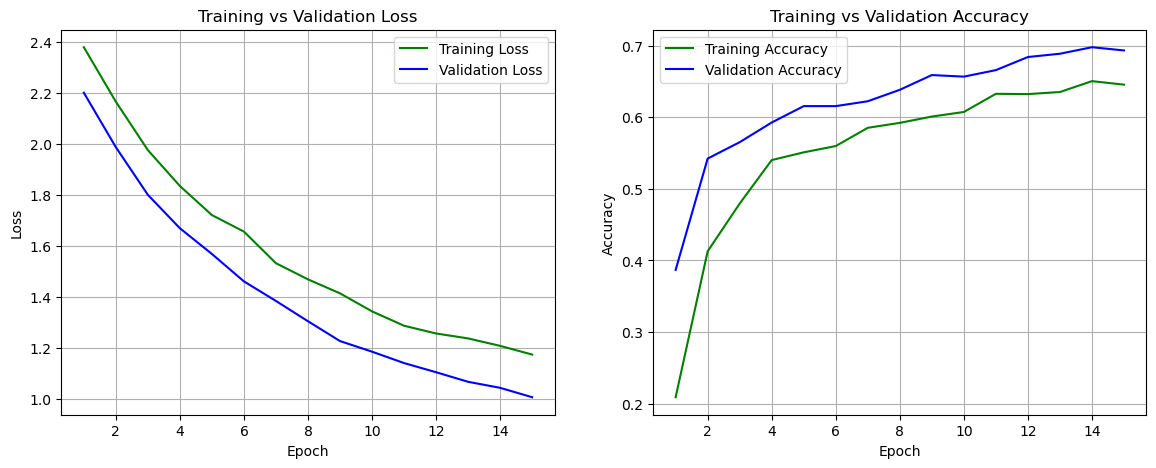

In [ ]:
train_losses = [
    2.3793,2.1659,1.9761,1.8356,1.7216,
    1.6569,1.5330,1.4697,1.4150,1.3444,
    1.2880,1.2577,1.2384,1.2092,1.1751
]

val_losses = [
    2.2011,1.9877,1.8010,1.6700,1.5692,
    1.4618,1.3851,1.3056,1.2280,1.1864,
    1.1418,1.1059,1.0684,1.0448,1.0080
]
train_accuracies = [
    0.2088,0.4127,0.4794,0.5402,0.5510,
    0.5598,0.5853,0.5922,0.6010,0.6074,
    0.6328,0.6324,0.6353,0.6505,0.6456
]
val_accuracies = [
    0.3867,0.5423,0.5652,0.5927,0.6156,
    0.6156,0.6224,0.6384,0.6590,0.6568,
    0.6659,0.6842,0.6888,0.6979,0.6934
]

import matplotlib.pyplot as plt
import seaborn as sns


epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

# ===== Loss Plot =====
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='green')
plt.plot(epochs, val_losses, label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# ===== Accuracy Plot =====
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='green')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.show()


Evaluation on Test Set

In [19]:
import torch

# تحميل أفضل أوزان للموديل
best_model = model  # نستخدم نفس الموديل اللي دربناه
state_dict = torch.load("best_efficientnet_b0_weighted.pth", map_location=device)
best_model.load_state_dict(state_dict)
best_model.to(device)

# تقييم على test_loader باستخدام نفس evaluate اللي عندك
test_loss, test_acc = evaluate(best_model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Test Loss: 1.0164
Test Accuracy: 0.6895


In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import torch

# اختبري أفضل وزن عندك
best_model = model
state_dict = torch.load("best_efficientnet_b0_weighted.pth", map_location=device)
best_model.load_state_dict(state_dict)
best_model.to(device)
best_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)

        outputs = best_model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# اطبع التقرير ✨
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))



Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.63      0.69        83
           1       0.65      0.66      0.65        61
           2       0.00      0.00      0.00         3
           3       0.55      0.65      0.59        51
           4       0.78      0.67      0.72        64
           5       0.50      1.00      0.67         2
           6       0.63      1.00      0.77        17
           7       0.79      0.79      0.79        80
           8       1.00      1.00      1.00         5
           9       0.59      0.62      0.60        65
          10       0.75      1.00      0.86         6
          11       0.50      1.00      0.67         1

    accuracy                           0.69       438
   macro avg       0.63      0.75      0.67       438
weighted avg       0.70      0.69      0.69       438



c:\Users\Njood\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Njood\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Njood\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
from sklearn.metrics import confusion_matrix
true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

cm = confusion_matrix(true_labels, predicted_labels)


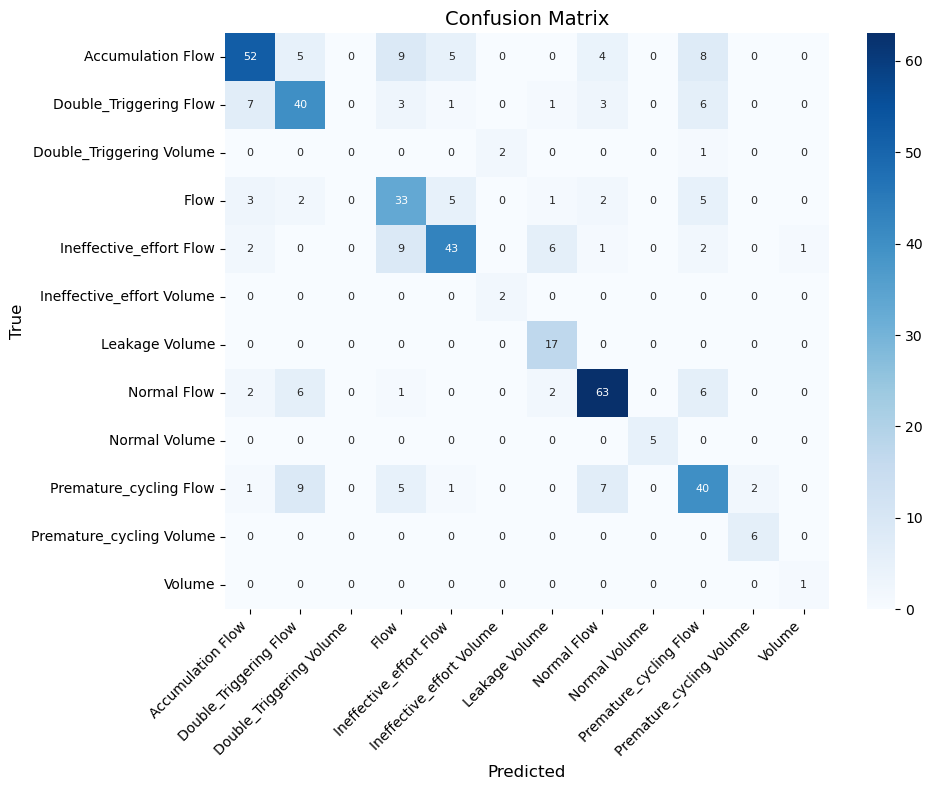

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix



plt.figure(figsize=(10, 8))

sns.heatmap(
    cm,
    annot=True,          # يكتب الأرقام داخل المربعات
    fmt="d",             # أرقام صحيحة
    cmap="Blues",        # الألوان
    xticklabels=CLASSES,
    yticklabels=CLASSES,
    annot_kws={"size": 8}   # حجم النص داخل المربعات
)

plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.0822659].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571

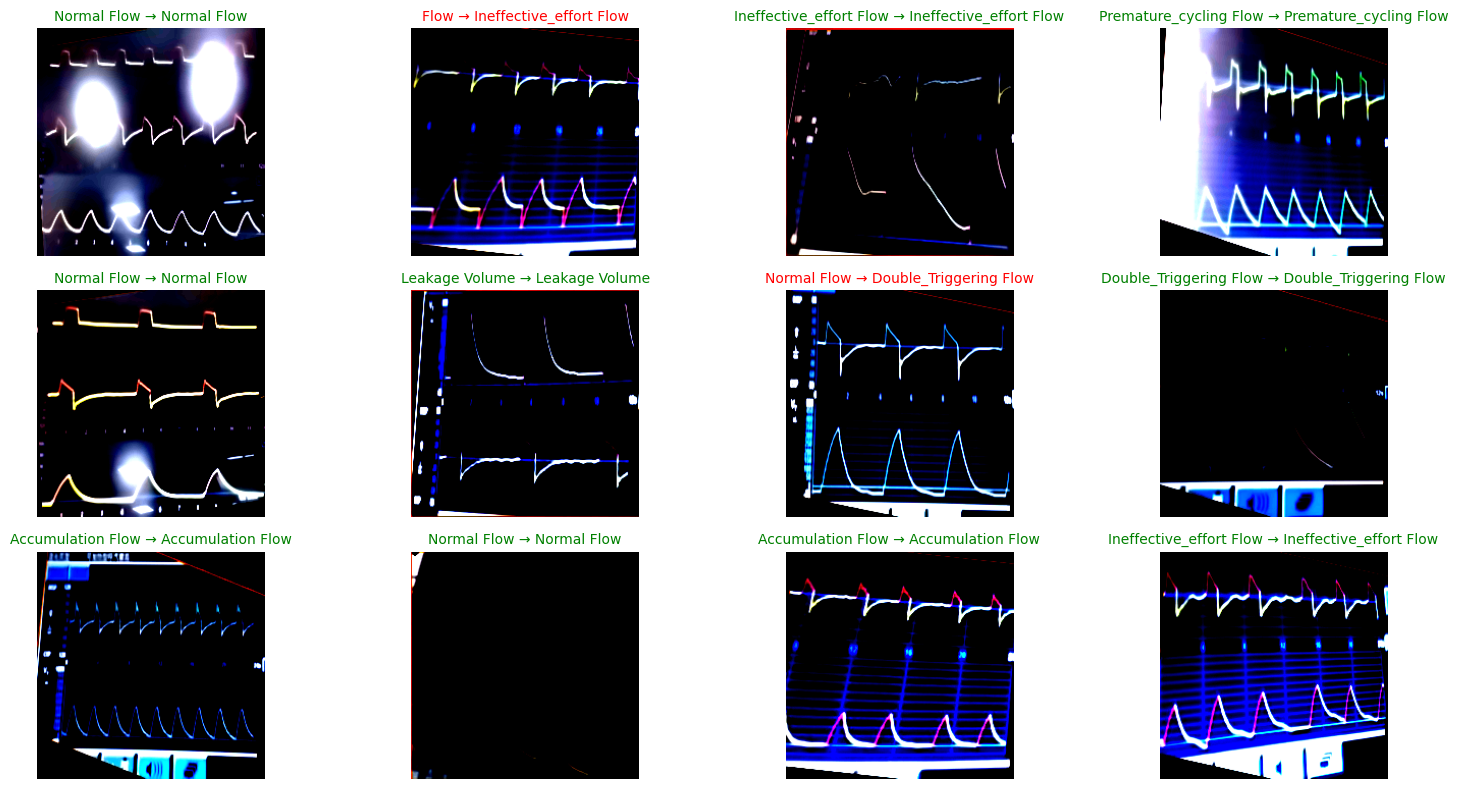

In [29]:
# %%
def show_predictions_grid(model, loader, class_names, device, num_images=12):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(16, 8))

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break

                img = images[i].cpu().permute(1, 2, 0).numpy()
                # لو فيه Normalization ممكن تحتاجين ترجعينه [0,1] أو [0,255] حسب البريبروسيس

                label = labels[i].item()
                pred = preds[i].item()

                true_name = class_names[label]
                pred_name = class_names[pred]

                ax = plt.subplot(3, 4, images_shown + 1)
                ax.imshow(img)
                ax.axis("off")

                title = f"{true_name} → {pred_name}"
                color = "green" if label == pred else "red"
                ax.set_title(title, color=color, fontsize=10)

                images_shown += 1

            if images_shown >= num_images:
                break

    plt.tight_layout()
    plt.show()

show_predictions_grid(best_model, test_loader, CLASSES, device, num_images=12)
